In [ ]:
!pip install nltk gensim fasttext transformers torch sentence-transformers

In [ ]:
import nltk
nltk.download("punkt_tab")

In [ ]:
TEXT="""
Préambule

Les parties conviennent de rappeler que cet avenant temporaire n’a pas vocation à perdurer dans le temps, mais uniquement à répondre à une situation d’urgence dans nos établissements, principalement ceux ouverts en continu. Il s’applique pour une durée de 3 mois, à l’issue de laquelle une évaluation de ses effets sera réalisée.

En effet, depuis le début de la crise sanitaire en mars 2020, des mesures dérogatoires ont été appliquées dans nos établissements, dans le cadre de l’état d’urgence qui a pris fin au 31 juillet 2022.

Ces mesures ont permis de maintenir l’ouverture de nos établissements H24 et ainsi garantir le service que nous devons aux personnes que nous accompagnons au quotidien.

Cet avenant temporaire constitue un palliatif provisoire à la situation actuelle de pénurie de professionnels à l’échelle nationale et tous secteurs confondus qui représente la menace la plus importante au maintien de notre activité.
En parallèle des éléments définis dans le présent accord, l’ADAPEI s’engage, à l’instar des dispositions prises sur la MAS de Biganos il y a plusieurs mois, à porter une attention particulière au FO/FH de Martignas et d’apporter les solutions organisationnelles nécessaires à l’amélioration de la situation existante.
"""

In [ ]:
TOKENS=nltk.tokenize.sent_tokenize(TEXT)

# Transformer les mots en vecteurs numériques (Word embeddings)

## 1 - One-Hot Encoder

* 1 token = 1 vecteur canonique

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

words=np.array([["rouge"],["bleu"],["vert"]])

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
onehot_encoded = encoder.fit_transform(words)

print(onehot_encoded)


* Défaut : tout est orthogonal/indépendant (alors que les synonymes sont proches)

## 2 - Word2vec

* Utilisation d'un réseau de neurones à trois couches pour modéliser les proba de prédire un mot en fonction de son contexte (cbow), ou un contexte en fonction d'un mot (skipgram)

### Continuous bag of words

e.g : 

* **Le petit garçon ___ jouer à la balle avec le chien**

aime / adore / préfère / déteste / haït



```
from transformers import pipeline
nlp = pipeline("fill-mask", model="camembert-base")
nlp(f"Le petit garçon {nlp.tokenizer.mask_token} jouer à la balle avec le chien.")



[{'score': 0.4084974527359009,
  'token': 5817,
  'token_str': 'adore',
  'sequence': 'Le petit garçon adore jouer à la balle avec le chien.'},
 {'score': 0.1012398898601532,
  'token': 1473,
  'token_str': 'aime',
  'sequence': 'Le petit garçon aime jouer à la balle avec le chien.'},
 {'score': 0.06638739258050919,
  'token': 3051,
  'token_str': 'préfère',
  'sequence': 'Le petit garçon préfère jouer à la balle avec le chien.'},
 {'score': 0.061637673527002335,
  'token': 198,
  'token_str': 'va',
  'sequence': 'Le petit garçon va jouer à la balle avec le chien.'},
 {'score': 0.02988985925912857,
  'token': 604,
  'token_str': 'veut',
  'sequence': 'Le petit garçon veut jouer à la balle avec le chien.'}]
```


-----

* **Le petit garçon adore jouer à la _____ avec le chien**

balle / marelle / plage / campagne


```
from transformers import pipeline
nlp = pipeline("fill-mask", model="camembert-base")
nlp(f"Le petit garçon adore jouer à la {nlp.tokenizer.mask_token} avec le chien.")


[{'score': 0.1584215611219406,
  'token': 5402,
  'token_str': 'souris',
  'sequence': 'Le petit garçon adore jouer à la souris avec le chien.'},
 {'score': 0.1299029439687729,
  'token': 269,
  'token_str': 'maison',
  'sequence': 'Le petit garçon adore jouer à la maison avec le chien.'},
 {'score': 0.10889659821987152,
  'token': 5417,
  'token_str': 'balle',
  'sequence': 'Le petit garçon adore jouer à la balle avec le chien.'},
 {'score': 0.058433305472135544,
  'token': 3094,
  'token_str': 'chasse',
  'sequence': 'Le petit garçon adore jouer à la chasse avec le chien.'},
 {'score': 0.04963257908821106,
  'token': 9862,
  'token_str': 'poupée',
  'sequence': 'Le petit garçon adore jouer à la poupée avec le chien.'}]
```

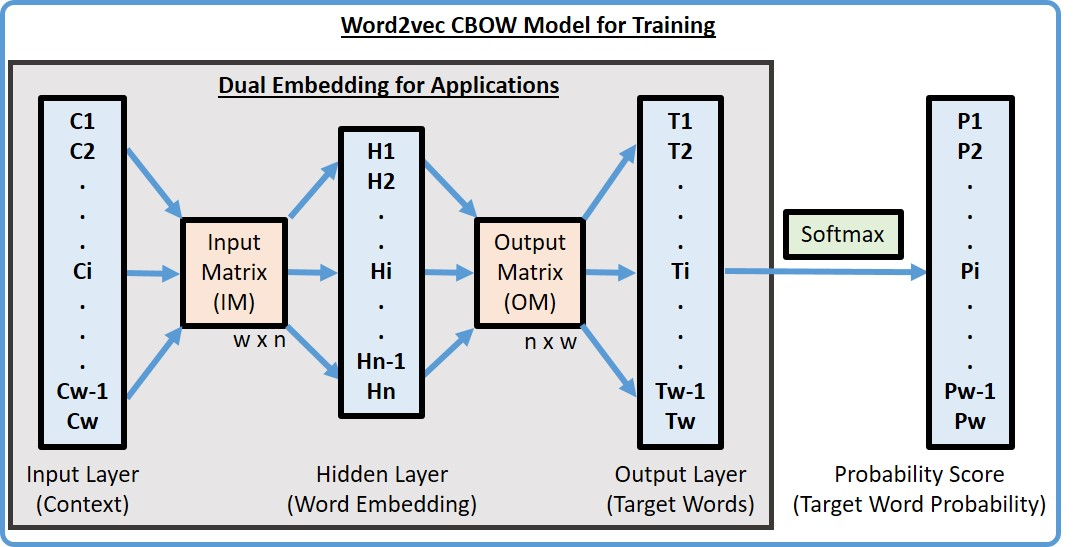
Source : https://lhncbc.nlm.nih.gov/LSG/Projects/CSpell/docs/designDoc/UDF/Ranker/cbow.html

A l'initialisation :

* poids aléatoire (de préférence non nulle)
* fonction d'activation de la couche cachée = Identité (une projection simple)

A l'entraînement : 

* Forward : on prend chacun des tokens du contexte (c1, c2, c3, c4, etc.), on projette avec la couche cachée et on moyennise
* On fait passer les résultats moyens de la couche cachée vers la couche de sortie
* On passe des réels aux proba avec une softmax, on calcule la perte entre prédit et réel (une fonction de dirac)
* On calcule les gradients et on fait la backpropagation
* On itère un certain nombre d'étape (epochs)

A "l'inférence" :
* On ne fait pas de l'inférence pure, l'idée n'est plus de classifier
* De ce fait, on enlève la couche de sortie
* On s'intéresse à la couche cachée, qui nous fournit une réprésentation plus dense de notre vecteur canonique
* Il suffit de faire le calcul matricielle, puisque la fonction est l'identité pour la couche cachée $Rep_w = I_m*C_w +b_m$

### Skipgram

* On entraîne toujours un réseau de neurones à trois couches, même architecture, mais la méthode est différente, car on souhaite prédire à partir d'un mot son contexte probable
* Pour cela, avec les données d'entraînement, on découpe en paires (mot, mot1_contexte); (mot, mot2_contexte) et essaie à partir du mot d'apprendre en moyenne les mots du contexte de manière indépendante
* "Le petit garçon aime jouer à la balle avec le chien"  et mot pivot "aime", à un contexte de deux mots = \[(aime,garçon),(aime,petit),(aime,jouer),(aime,à)\], cela donne quatre exemples indépendants
* Même chose, après entraînement, on enlève la couche de sortie pour obtenir les vecteurs projetés à partir de la couche cachée

### From scratch avec gensim

In [ ]:
TOKENS

In [ ]:
tokenized_sentences = [nltk.tokenize.word_tokenize(sentence.lower()) for sentence in TOKENS]

# Print tokenized sentences
print(tokenized_sentences)

In [ ]:
#CBOW
from gensim.models import Word2Vec
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=0)
model.save("word2vec.model")


In [ ]:
#Skipgram
from gensim.models import Word2Vec
model2 = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)
model2.save("word2vec2.model")

In [ ]:
model.wv['palliatif']

In [ ]:
similar_words = model.wv.most_similar('palliatif', topn=5)
similar_words

## 3 - Glove : un concurrent

* Word2vec utilise la concordance, i.e. les mots directement proches aux alentours avec une taille de contexte
* L'idée de Glove est plutôt d'utiliser la cooccurrence, les mots qui occurent ensemble indépendemment de la distance dans la phrase

In [ ]:
from gensim.models import KeyedVectors
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-100")

# Load pre-trained Word2Vec model
#path_to_model = 'GoogleNews-vectors-negative300.bin.gz'  # Path to the downloaded model
#model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)

# Example: Get vector for 'king'
print(model['king'])

## 4 - Fasttext : Word2vec amélioré

* Même chose que Word2vec, mais plutôt que les tokens soient des mots, les tokens sont des sous-mots/syllabes
* Cela permet d'avoir une représentation vectorielle de mot qui n'était pas dans le vocabulaire initial

In [ ]:
import fasttext.util
fasttext.util.download_model('fr', if_exists='ignore')  # English
ft = fasttext.load_model('cc.fr.300.bin')

In [ ]:
ft.get_nearest_neighbors('Bonjour')

In [ ]:
ft.get_word_vector('Bonjour')


## 5 - Embedding contextuel : BERT / GPT et transformers

* Un mot peut signifier des choses différentes selon les contextes, selon la place ou rôle dans la phrase, selon l'article (in)défini précédent

* Le page != La page ; J'allume la cuisinière pour préparer un plat != Je discute avec la cuisinière ; L'opéra est à deux mètres != le chirurgien opéra le petit garçon

* (https://www.francaisfacile.com/exercices/exercice-francais-2/exercice-francais-3329.php)

* De ce fait, avoir une réprésentation vectorielle pour un mot n'est pas suffisant, il faut en avoir plusieurs, en fonction des autres.

* Jusqu'à présent, les algorithmes ci-dessus ne prennaient pas en compte l'ordre des mots (sac de mots)

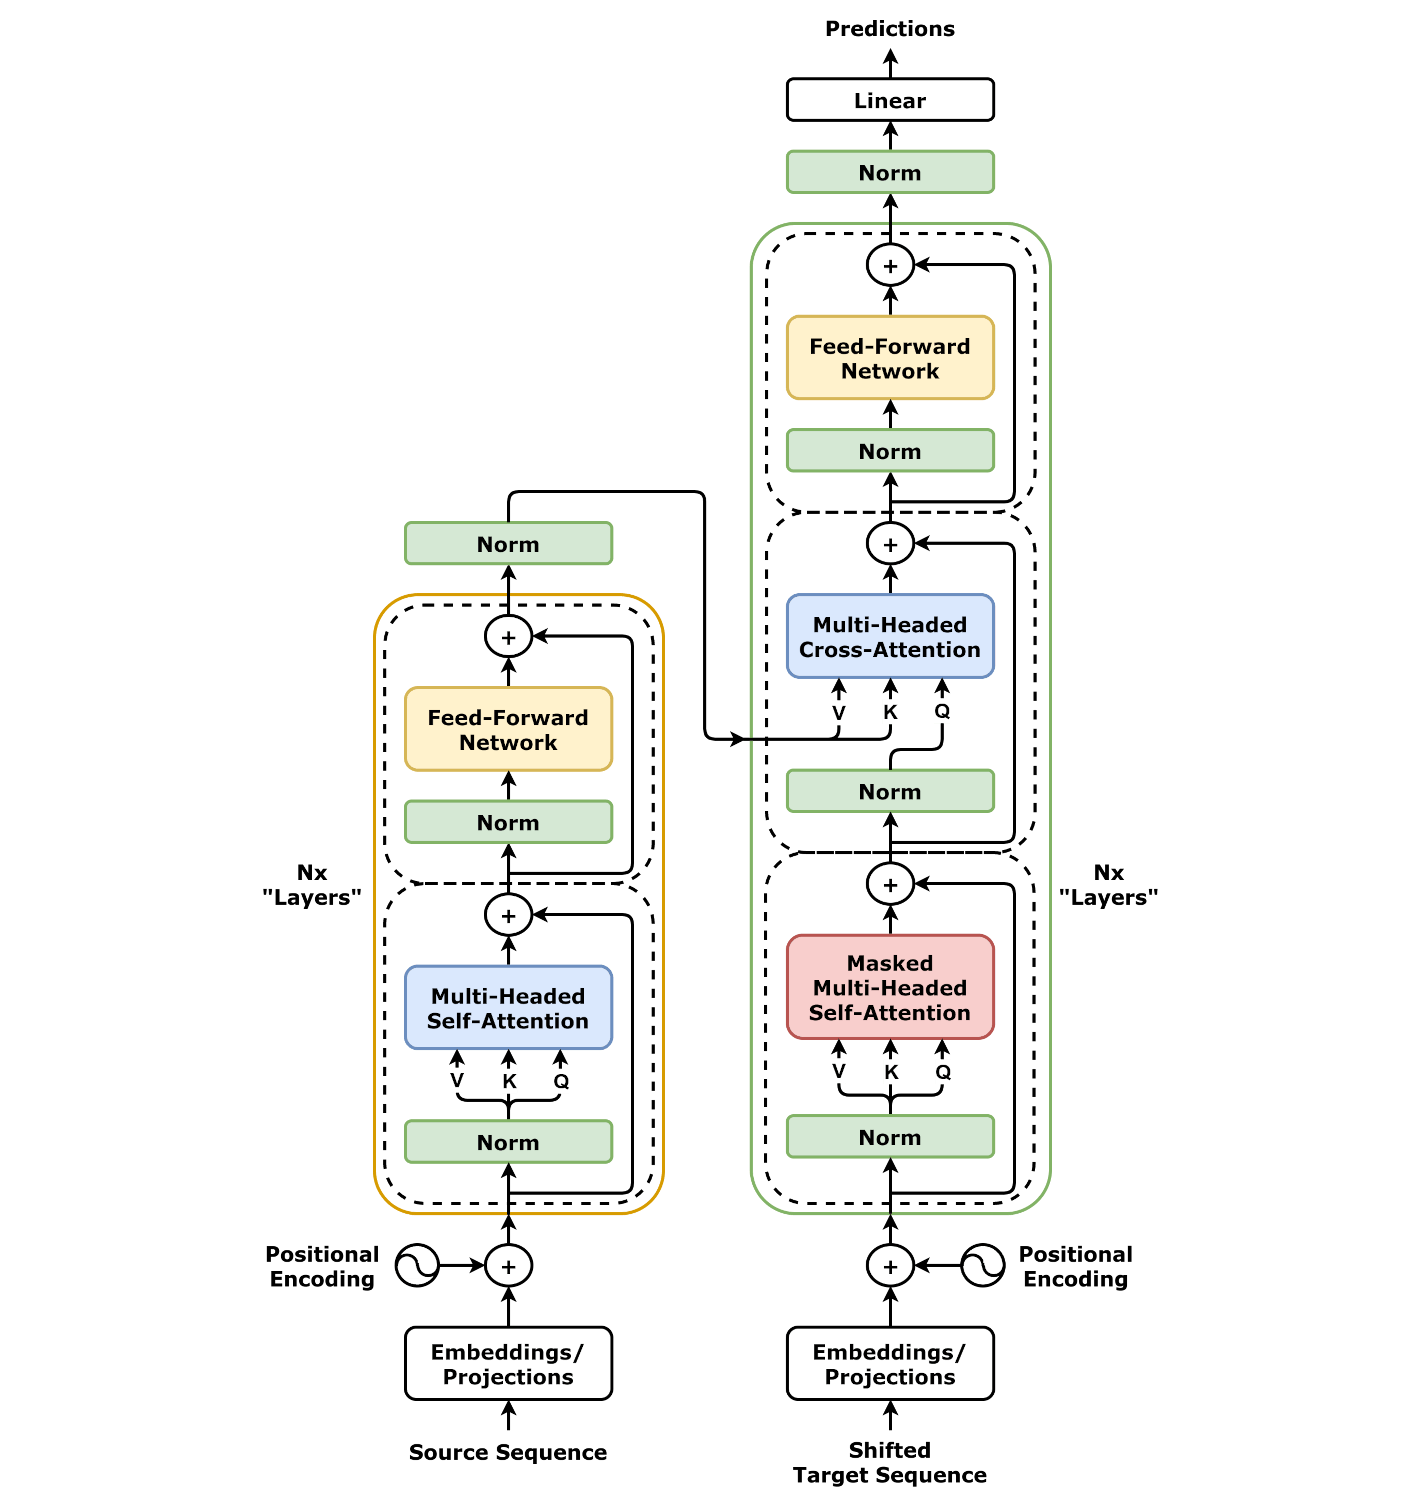

* Dans le cas de l'embedding de BERT, on prend un vocabulaire de taille n, on crée une projection vers une couche cachée de taille m < n
* On encode la position de 0 à L, et on crée une projection vers une couche cachée de taille m également
* On encode également le type de token, s'il y a deux typologies dans une paire par exemple ("model","humain") et on crée une projection vers une couche cachée de taille m
* La représentation vectorielle d'un token de la phrase est alors la somme des trois !
* Ainsi, la représentation vectorielle du mot "cuisinière" est différente pour "J'allume la cuisinière pour préparer un plat" et pour "Je discute avec la cuisinière"
* On a alors une représentation vectorielle dynamique et contextuelle
* Le petit chien joue avec le chat ; Le chien joue avec le petit chat

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Input text
text = "Le petit chien joue avec le chat"

# Tokenize the input text
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

inputs

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist())
tokens

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

petit_embedding = last_hidden_states[:, 2, :]

In [ ]:
# Input text
text = "Le chien joue avec le petit chat"

# Tokenize the input text
inputs2 = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

inputs2

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(inputs2["input_ids"][0].tolist())
tokens

In [ ]:
with torch.no_grad():
    outputs2 = model(**inputs2)

last_hidden_states2 = outputs2.last_hidden_state

petit_embedding2 = last_hidden_states2[:, 9, :]


In [ ]:
petit_embedding[0,:10]

In [ ]:
petit_embedding2[0,:10]

In [ ]:
positional_embeddings = model.embeddings.position_embeddings
positional_embeddings.weight.data[0,:10]

In [ ]:
token_type_embeddings = model.embeddings.token_type_embeddings
token_type_embedding_values = token_type_embeddings.weight.data
token_type_embedding_values

## 6 - Passer du mot à la phrase

* moyenne (fasttext), max, somme des vecteurs
* SentenceBert (SBERT), entraîné à la tâche de 'Semantic Textual Similarity'

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# List of sentences
sentences = [
    "Le chien joue avec le petit chat",
    "Le petit chien joue avec le chat"
]

# Generate embeddings
embeddings = model.encode(sentences)

# Calculate similarity
similarity = cosine_similarity([embeddings[0]], [embeddings[1]])
print("Similarity between sentence 1 and 2:", similarity[0][0])
